# Convert Data Files to WISP Format for Spectral Fitting

**Author:** Mitchell Revalski

**Adapted:** Kalina V. Nedkova and James Colbert

**Last Updated:** July 12, 2024

***

## Jupyter Notebook for the MUSE Ultra Deep Field Program

This notebook was created by Dr. Mitchell Revalski to convert the HST passage and VLT MUSE spectroscopic files provided by Dr. Nor Pirzkal and Dr. Matteo Fossati into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the MUDF program.

Please send questions, comments, and suggestions to Mitchell Revalski at [mrevalski@stsci.edu](mrevalski@stsci.edu). Thank you, and have a nice day!

***

## This version has been adapted for PASSAGE

The updated version of this notebook converts JWST 1D spectroscopic files produced by grizli into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the PASSAGE program.

Moreover, in an optional step 3, 1D spectroscopic files are created for the individual orientations (R grism & C grism). The location of the beam files from grizli needs to be specified for this step. 

Please send questions, comments, and suggestions w.r.t. the PASSAGE updates to Kalina at [knedkova@stsci.edu](knedkova@stsci.edu). 
Special thank you to James Colbert for fixing a bug that caused this code to crash if the F150W grism filter does not exist. 

***


## Software

The Python environment (ac6) used to run this notebook was built using conda:<br>
<code>
(base) asteropaios:Documents mrevalski$ conda create -n ac6 stsci
(base) asteropaios:Documents mrevalski$ conda activate ac6
(ac6) asteropaios:Documents mrevalski$ conda update drizzlepac
(ac6) asteropaios:Documents mrevalski$ conda deactivate
</code>

The jupyter notebook can then be run using the following call sequence:<br>
<code>
(base) asteropaios:conversion mrevalski$ conda activate ac6
(ac6) asteropaios:conversion mrevalski$ jupyter notebook
</code>

The critical package versions include:<br>
<code>
Python Version [GCC Clang 10.0.0] 3.6.13 |Anaconda, Inc.|
(default, Feb 23 2021, 12:58:59) 
numpy Version -> 1.19.2 
astropy Version -> 4.0.2
</code>  

***

## Table of Contents <a class="anchor" id="tag0"><a>


**&emsp; 1) [Setup Options](#setup)<br>**
**&emsp; 2) [Convert PASSAGE](#passage)<br>**
**&emsp; 3) [Create 1D spectra for each orientation](#orientations)<br>**
    
*** 

## Imports

The following packages are required to run the Jupyter Notebook:
 - *os* - change and make directories
 - *glob* - determine files in folders
 - *numpy* - math and array functions
 - *pandas* - data structure functions    
 - *astropy* - file and data handling
      - *io.fits* - import FITS files
      - *table.Table* - display formatted tables

In [2]:
import os
import glob
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table, vstack
from time import time

import grizli
print(grizli.__version__)

from grizli import utils, multifit
from grizli.pipeline import auto_script

utils.set_warnings()

1.11.10
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


## Setup Options  <a class="anchor" id="setup"><a>
[Table of Contents](#tag0)

In [3]:
# main directory
main_directory = '/Users/knedkova/Work/2024PASSAGE/'
par_names = ['Par28']

# grism data directory
spec1D_directory = main_directory+'data/'+par_names[0]+'/spec1D/'

# where all the parallel field data live
data_directory = main_directory+'data/'+par_names[0]+'/'

In [4]:
os.chdir(spec1D_directory)

## Convert passage  <a class="anchor" id="passage"><a>
[Table of Contents](#tag0)

1. In order for the wavelet solutions to work, the 'RADESYS' keyword in the header must be either updated or removed. 

In [264]:
#check if already updated for first object. If yes -> do nothing, if not -> update RADESYS in all fits headers

for k in par_names:
    files = glob.glob(main_directory+'data/'+str(k)+'/Stamps/*.fits')
    test_file = fits.open(files[0])
    header = test_file[2].header
    
    if header['RADESYS'] != 'ICRS':
        print('Headers are not updated. Updating all now.')
        hdulist = fits.open(main_directory+'data/'+str(k)+'/Stamps/*.fits')

        for j in files:
            # Open the file header for viewing and load the header
            hdulist = fits.open(j)
            for i in range(len(hdulist)):
                header = hdulist[i].header
                try: header['RADESYS'] = 'ICRS'
                except: print('no RADESYS in header')
            
            hdulist.writeto(j, overwrite='True')


2. Now create 1D spectral files

In [384]:
# flag for creating the output files regardless of whehter they already exist
# True = create new files
# False = create new files only if they do not exist 
create_files_anyway = True

In [270]:
for i in par_names:
    
    try:os.mkdir(data_directory)
    except:print('I did not make your directory')
    try:
        os.chdir(data_directory)
        os.mkdir('Spectra')
    except:print('I did not make your directory')
    
    os.chdir(spec1D_directory+str(i))
    print('moving to:', spec1D_directory+str(i))
    files = sorted(glob.glob('*1D.fits'))

    # Check if converted files already exist. If they do not, carry on with the conversion. 
    # Otherwise, this step can be skipped. 
    # Here, I just check if there are more converted files than objects (there can be 1-3 per object)
    # depending on how many filters are available for each object
    already_converted_files = glob.glob(data_directory + 'Spectra/*.dat')
    if len(files) >= len(already_converted_files) or create_files_anyway == True:
        print(len(already_converted_files))
        print(len(files))
    
        print('\nThere are ' + str(len(files)) + ' PASSAGE files to convert.\n')
        for f in files[-2:-1]:
            os.chdir(spec1D_directory+str(i))
            #os.chdir(spec1D_directory+par_names[0]+'/')
            fff = fits.open(f)
            print(fff.info)

            for ext in range(1, len(fff)):
                
                tb = Table.read(fff[ext], format='fits').to_pandas()
                t_out = pd.DataFrame({})
            
                t_out['wave'] = tb['wave']
                t_out['flux'] = tb['flux']/tb['flat']
                t_out['error'] = tb['err']/tb['flat']
                t_out['contam'] = np.zeros(len(tb['wave'])).astype('int')
                t_out['zeroth'] = np.zeros(len(tb['wave'])).astype('int')
                t_out = Table.from_pandas(t_out)
                t_out = t_out.filled(0.0) # Replace nans with zeros
                # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
                t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
                t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])
    
                print('saving to '+ data_directory + '/Spectra' )
                os.chdir(data_directory + '/Spectra' )
    
                # Write out the updated files.
                if fff[ext].header['EXTNAME'] == 'F200W':
                    _indexes_ = [i for i in range(len(fff[ext].data))]
                    try:_indexes_ = [i for i in _indexes_ if t_out['wave'][i] > max(Table.read(fff[ext-1])['wave']) ]
                    except:pass
                    t_out[_indexes_].write(os.path.basename(f).replace('1D.fits', 'G200_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)      
                
                # Write out the updated files.
                if fff[ext].header['EXTNAME'] == 'F150W':
                    #t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D_uncomb.dat'), 
                    t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)
                    
                elif fff[ext].header['EXTNAME'] == 'F115W':
                    t_out.write(os.path.basename(f).replace('1D.fits', 'G115_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)

        # THE BELOW IS NO LONGER NEEDED. 
    
        # Now that the .dat files have been created/updated, need to combine the F200W with the F150W
        # # since the next code expects only 2 grism filters.
        # os.chdir(data_directory + '/Spectra' )

        # target_dir = data_directory + 'Spectra'
        # F200s = glob.glob(target_dir+'/*G200_1D.dat')
        
        # for i in range(len(F200s)):
            # F150s = F200s[i].split('G200_1D.dat')[0]+str('G150_1D_uncomb.dat')
            # tb_200 = Table.read(F200s[i], format='ascii')
            # if os.path.exists(F150s):
                # tb_150 = Table.read(F150s, format='ascii')
                    
            # tout = vstack([tb_150, tb_200])
            # print(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'))
                
            # tout.write(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'), 
                            # format='ascii.fixed_width_two_line', overwrite=True)


    else: print('It appears the .dat files were already created for this field. Skipping this step.')
    


I did not make your directory
I did not make your directory
moving to: /Users/knedkova/Work/2024PASSAGE/data/Par28/spec1D/Par28
26858
2754

There are 2754 PASSAGE files to convert.

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7a8be10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b77e8350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59d190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d389d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ec6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29cd93810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af85b410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:49:21,395 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:21,395 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:21,395 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64d950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af7be0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x316178c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315224690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b77eaad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca19d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d30750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f965950>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:29,895 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:29,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:29,896 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdc31050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b790afd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af832650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31617bb90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e7be90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b77eb290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f967810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc30750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:30,461 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:30,461 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:30,462 - stpipe - WARNING - 
2024-07-23 08:49:30,469 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:30,470 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:30,470 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1eff90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711ae90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd30d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31617b210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed620bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7a8aa90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2afb42390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:31,200 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:31,200 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:31,200 - stpipe - WARNING - 
2024-07-23 08:49:31,207 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:31,207 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:31,207 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f966a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec0c73d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec183110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efc248d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f81d990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b061f250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc33610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f964a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:36,666 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:36,666 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:36,667 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fd60a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314dedc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59c6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64da90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec040c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b77ea390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7f7dc10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314dec150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:42,140 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:42,140 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:42,140 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fd608d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed253f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e78a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca25d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:49:42,347 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:42,348 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:42,348 - stpipe - WARNING - 
2024-07-23 08:49:42,355 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:42,356 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:42,356 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f965090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59de50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fd60fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f81fd10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ed390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e5d50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3afc90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4afa90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:46,947 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:46,947 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:46,947 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64c150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x316178110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec456a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff77b50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdca1a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d37490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ad610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ac250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:49,234 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:49,235 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:49,235 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdca0e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64fb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff75e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff778d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda71f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e4750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b07e5390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0cd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:49:55,440 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:55,441 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:55,441 - stpipe - WARNING - 
2024-07-23 08:49:55,448 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:49:55,448 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:49:55,448 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e73550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec710210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2810>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda72350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3152244d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3152267d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:03,047 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:03,047 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:03,047 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493dad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b07eb490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e198050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda720d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:50:03,282 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:03,283 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:03,283 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1eff10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ad310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec713a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cd9b3ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64fcd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719d910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff76b10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:04,566 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:04,566 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:04,566 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x315224490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493d810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d3450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d1350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cf5d3210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59f310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af8b7890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b03d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:06,669 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:06,669 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:06,670 - stpipe - WARNING - 
2024-07-23 08:50:06,676 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:06,676 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:06,676 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e70bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1eda90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493e6d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2afaa57d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebe8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e730d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d05d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:09,254 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:09,254 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:09,254 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x315226450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efbbb0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed8d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719fb10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b07eb910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719cf10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4afb90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:11,057 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:11,057 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:11,058 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493ce10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d363d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719da10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff67890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e199cd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:11,792 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:11,793 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:11,793 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493f710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e5690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d1690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ed4e4f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e198c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebc510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:20,490 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:20,490 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:20,490 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64dd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efbb9250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af8b6110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72b10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719ff10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec181110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff67290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317123f10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:24,755 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:24,756 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:24,756 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebe450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec181c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ad090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe28890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2bd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e72c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3152254d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:36,657 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:36,657 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:36,657 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ec450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711bbd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59d710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc89990>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda72050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d2a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e73bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64bd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:41,075 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:41,075 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:41,075 - stpipe - WARNING - 
2024-07-23 08:50:41,082 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:41,082 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:41,083 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711bb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d3d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3171203d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719cc50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec713210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711b610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefe3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe28dd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//S

2024-07-23 08:50:44,465 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:44,465 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:44,466 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3148b5c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebe890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe288d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe28c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315225a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efbbb9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad42d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:45,751 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:45,751 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:45,751 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2af85acd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad6690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fad7f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff778d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317119210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc8bb10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:47,045 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:47,045 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:47,045 - stpipe - WARNING - 
2024-07-23 08:50:47,052 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:47,053 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:47,053 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1efed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e73dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719c9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719d590>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec77da90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2ac10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d39190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59f710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:52,443 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:52,443 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:52,443 - stpipe - WARNING - 
2024-07-23 08:50:52,450 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:52,450 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:52,450 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebdc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e5890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e70c50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fad7e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719f790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719de90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebdb50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//S

2024-07-23 08:50:57,967 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:57,968 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:57,968 - stpipe - WARNING - 
2024-07-23 08:50:57,974 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:57,975 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:57,975 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3aead0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d3b2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317118550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fad7f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b79cd610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ad890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:50:59,442 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:50:59,442 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:50:59,442 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64db50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad6690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3af850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc8be90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64f150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29dc3d290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec454650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226d50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:01,625 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:01,625 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:01,625 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x315225450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64e490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d38a10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda73250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b06d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b5c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ae550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:02,168 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:02,168 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:02,168 - stpipe - WARNING - 
2024-07-23 08:51:02,175 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:02,175 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:02,176 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ece10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af85a190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe28050>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493ff10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b6fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d3b2d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ed950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec456e10>, <astropy.io.fits.hdu.table

2024-07-23 08:51:02,776 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:02,776 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:02,776 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda71050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff65f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64ef90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebdc90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493c190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493e7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//S

2024-07-23 08:51:05,515 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:05,516 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:05,516 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e4ad090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77fc10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7d39a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff646d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e4190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b2450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e367610>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:20,975 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:20,975 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:20,975 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ee690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64c9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2b2d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ed623610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b0c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff671d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e199cd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda72750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315224690>, <astropy.io.fits.hdu.table

2024-07-23 08:51:23,421 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:23,421 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:23,421 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3148b5090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d2050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad6550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3ad7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4af410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:25,244 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:25,245 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:25,245 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ec750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad4250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed623350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4aea10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdefecd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3aebd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315225ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ec550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:30,181 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:30,181 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:30,181 - stpipe - WARNING - 
2024-07-23 08:51:30,188 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:30,188 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:30,189 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711b0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b69d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719fe10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebce90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec180050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e7350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff74850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:32,762 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:32,762 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:32,763 - stpipe - WARNING - 
2024-07-23 08:51:32,770 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:32,770 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:32,770 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1ed610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317123810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af3fc410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd32190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdc8b350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad6bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ec4d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3ad950>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:35,200 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:35,200 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:35,201 - stpipe - WARNING - 
2024-07-23 08:51:35,208 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:35,209 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:35,209 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff648d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f964dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e72090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:51:35,442 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:35,443 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:35,443 - stpipe - WARNING - 
2024-07-23 08:51:35,451 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:35,451 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:35,452 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x317123210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec710450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64f710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77ed10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fad7f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d37850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3afc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3addd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:36,789 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:36,789 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:36,789 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7909e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad5750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2afb41650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefed90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2bc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd320d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d36dd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//S

2024-07-23 08:51:37,518 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:37,519 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:37,519 - stpipe - WARNING - 
2024-07-23 08:51:37,526 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:37,526 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:37,526 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719eed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2849d9c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d34c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd32250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebd7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f965e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff74bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e366d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:48,720 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:48,720 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:48,720 - stpipe - WARNING - 
2024-07-23 08:51:48,727 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:48,728 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:48,728 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec181050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b09096d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec183190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3af210>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3aeb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77ec50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc89150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2b550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:49,654 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:49,654 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:49,654 - stpipe - WARNING - 
2024-07-23 08:51:49,661 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:49,661 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:49,662 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493dd10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2884a4550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda71b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e3651d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:51:49,896 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:49,897 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:49,897 - stpipe - WARNING - 
2024-07-23 08:51:49,905 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:49,906 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:49,906 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2af85b210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc88fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebf3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493dd90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31617b350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc8bf50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493c850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:51:52,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:52,263 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:52,264 - stpipe - WARNING - 
2024-07-23 08:51:52,270 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:51:52,271 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:51:52,271 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3ad650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719ee10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd32ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed4d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3af710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77c790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b7c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3afd10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:02,475 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:02,475 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:02,475 - stpipe - WARNING - 
2024-07-23 08:52:02,482 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:02,482 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:02,482 - stpipe - WARNING - 
2024-07-23 08:52:02,488 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:02,489 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:02,489 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719e610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd31650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e364910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4aef10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7b003d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59c910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b4790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:08,496 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:08,497 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:08,497 - stpipe - WARNING - 
2024-07-23 08:52:08,504 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:08,504 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:08,504 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x315225210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefda50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d53c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ec990>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebc910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d0050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493f2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec182d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:52:08,909 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:08,909 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:08,909 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x316179190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29dc3d290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefd210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719fd10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e72710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1edc90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d342d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29d2403d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:09,900 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:09,901 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:09,901 - stpipe - WARNING - 
2024-07-23 08:52:09,908 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:09,908 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:09,908 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe28bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59db50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719edd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec457150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x317118550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f966550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4af350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:52:10,312 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:10,312 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:10,312 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdca2490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2afb41b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64e690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d08d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b12fd5d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b03e25d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719f150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315224ad0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:11,768 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:11,768 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:11,768 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efd32c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af859c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77cd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317119310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec77cb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd30bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64da50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317119150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:14,635 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:14,636 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:14,636 - stpipe - WARNING - 
2024-07-23 08:52:14,643 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:14,643 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:14,643 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e4ae450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e198650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca1490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad5bd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec77c410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29ce9eb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f1d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ac288510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:52:14,864 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:14,864 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:14,865 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cf59d090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af4324d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719f650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6e50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719d2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e70910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1eddd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af85b490>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:17,179 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:17,179 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:17,179 - stpipe - WARNING - 
2024-07-23 08:52:17,186 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:17,186 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:17,186 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec77fbd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b79cc690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226fd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30fad7f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ae050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2b150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:19,042 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:19,042 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:19,042 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e367ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af859710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493f1d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff75250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f965090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af4f1dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7b00510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:20,299 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:20,299 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:20,300 - stpipe - WARNING - 
2024-07-23 08:52:20,307 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:20,307 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:20,307 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3148b4b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317122f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b7909690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64d1d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f966dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebd690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b4890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0b90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:29,433 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:29,434 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:29,434 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64d7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d36790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77c910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdb6c190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ed4e67d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4af750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64ea90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdb6c190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:31,305 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:31,305 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:31,306 - stpipe - WARNING - 
2024-07-23 08:52:31,312 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:31,312 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:31,312 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711a150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2afe80110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca1490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd312d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec712150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d2910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cddce450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314f15a10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:35,048 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:35,048 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:35,048 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efd31950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b0334750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719d2d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64da10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec180090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b09087d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdeffc10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:41,907 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:41,907 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:41,907 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64c410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f966710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec181c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efd33e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b12ffb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719df10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af54cc50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:43,362 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:43,362 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:43,362 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebc910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29c1e4550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d1610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b07eaa10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e730d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711a9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64e910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64e10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:48,895 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:48,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:48,896 - stpipe - WARNING - 
2024-07-23 08:52:48,903 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:48,903 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:48,903 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3152240d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719ed50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719e2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d37490>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493cc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad7590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2afa83dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e7a90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:50,191 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:50,191 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:50,192 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e70090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4adfd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebc350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b7e4af10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d3450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefdcd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d37150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:51,827 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:51,828 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:51,828 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2ac10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711a910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af85bd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefd450>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64da90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314f17fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd305d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64edd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:54,875 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:54,875 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:54,876 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e734d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f9678d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed1ef3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca1310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e4ad090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e198e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719f8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3171186d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:52:57,010 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:52:57,010 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:52:57,011 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x315225790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711a650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31617b210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64810>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cf5d0c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719eb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ac910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77ec50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:05,300 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:05,300 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:05,300 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff67b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59d0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca0bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f966190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebc690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec712f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc89150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:08,853 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:08,854 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:08,854 - stpipe - WARNING - 
2024-07-23 08:53:08,861 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:08,861 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:08,861 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314d34e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebc690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc88bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719d350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cf5d3210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefd390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b1d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64f3d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:13,313 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:13,313 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:13,313 - stpipe - WARNING - 
2024-07-23 08:53:13,320 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:13,320 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:13,321 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711a990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebed90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227c90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64da90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x316179690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff64bd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:16,884 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:16,884 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:16,885 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2a610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4ae050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317122ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64c650>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe28d50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff65bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2ad10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317122ed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:20,106 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:20,107 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:20,107 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f966550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59dd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315224f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc88d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec1edb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af7047d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719c750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77d8d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:21,386 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:21,386 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:21,386 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314d530d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefd5d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff65bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f950>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711bad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe29150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1eccd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:22,282 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:22,282 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:22,283 - stpipe - WARNING - 
2024-07-23 08:53:22,289 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:22,290 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:22,290 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719d410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca1510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec457dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d3350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ed4e67d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e4f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59c350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ee9d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:33,803 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:33,803 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:33,803 - stpipe - WARNING - 
2024-07-23 08:53:33,810 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:33,810 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:33,810 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64d090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b3c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec711450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b4c50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cd9b2ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29e113e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59c790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed623b90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:53:35,827 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:35,827 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:35,828 - stpipe - WARNING - 
2024-07-23 08:53:35,834 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:53:35,835 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:53:35,835 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe29e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec710490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b5410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff77f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebc7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed623850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:54:07,376 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:07,377 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:07,377 - stpipe - WARNING - 
2024-07-23 08:54:07,384 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:07,384 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:07,384 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff75290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d0650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e68d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b06d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64d290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e73990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59ea90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:54:26,172 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:26,173 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:26,173 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e73610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efbbad10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec796110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59e650>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e4ace10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64c8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e365550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda71150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:54:46,522 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:46,522 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:46,522 - stpipe - WARNING - 
2024-07-23 08:54:46,528 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:46,528 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:46,529 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e73f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b2d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2bc90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d376d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec713210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e72e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64f850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64d450>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:54:53,922 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:53,923 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:53,923 - stpipe - WARNING - 
2024-07-23 08:54:53,929 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:53,930 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:53,930 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31711b990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d36fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdca2090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ed0d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2bcd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff65dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b0335e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b1a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:54:54,151 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:54:54,151 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:54:54,151 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31493c9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe29150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317118550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719d0d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e73d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda73c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59d610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed620050>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:05,369 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:05,369 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:05,369 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff65f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af54c390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed620850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc8a410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdca0690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec181c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff75790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b4110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:16,663 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:16,663 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:16,663 - stpipe - WARNING - 
2024-07-23 08:55:16,669 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:16,670 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:16,670 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff75490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b4890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdefed90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed621b50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31719e0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed7787d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdb6dcd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493d5d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:21,967 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:21,967 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:21,967 - stpipe - WARNING - 
2024-07-23 08:55:21,973 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:21,974 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:21,974 - stpipe - WARNING - 
2024-07-23 08:55:21,980 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:21,980 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:21,981 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2aed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2af431f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efbb9790>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f965090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29e113e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719c6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff746d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:55:22,372 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:22,372 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:22,373 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2a710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f9670d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3171186d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711a790>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2a910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe29e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd33890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed623c50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:32,659 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:32,659 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:32,659 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efd30210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719cf50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29cd18990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e71cd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efd30d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2b750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec180050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b5510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:35,012 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:35,013 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:35,013 - stpipe - WARNING - 
2024-07-23 08:55:35,021 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:35,021 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:35,021 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x317119ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719df10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e199790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cdc88d10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e4ac3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1833d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e64dc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efcccb10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:36,168 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:36,169 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:36,169 - stpipe - WARNING - 
2024-07-23 08:55:36,176 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:36,176 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:36,176 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f965b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719c150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd32e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed6206d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:55:36,393 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:36,393 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:36,393 - stpipe - WARNING - 
2024-07-23 08:55:36,400 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:36,400 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:36,400 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x317122150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d50a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec710610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f967d50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2b07eb210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe2a8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31719f8d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:40,147 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:40,148 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:40,148 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e71350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff67b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3148b75d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe294d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff77ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711ae50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec4562d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6050>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:58,722 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:58,722 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:58,722 - stpipe - WARNING - 
2024-07-23 08:55:58,729 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:58,729 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:58,729 - stpipe - WARNING - 
2024-07-23 08:55:58,736 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:58,736 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:58,736 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64d390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77ee10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315226b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4acb90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30e64f910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31711a2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cd9b2c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ec990>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:55:59,823 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:59,824 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:59,824 - stpipe - WARNING - 
2024-07-23 08:55:59,830 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:59,830 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:59,831 - stpipe - WARNING - 
2024-07-23 08:55:59,838 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:55:59,838 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:55:59,838 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3af190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff770d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efe28910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e719d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3148b5650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff67450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314f14fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec3ac390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra


2024-07-23 08:56:00,222 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,222 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,222 - stpipe - WARNING - 
2024-07-23 08:56:00,229 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,229 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,229 - stpipe - WARNING - 
2024-07-23 08:56:00,236 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,236 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,236 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x30f9664d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd30e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314d34dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30e4af610>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2efe2b350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ed4e6550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff76a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec1ee650>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:56:00,970 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,970 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,971 - stpipe - WARNING - 
2024-07-23 08:56:00,977 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,978 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,978 - stpipe - WARNING - 
2024-07-23 08:56:00,984 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:00,985 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:00,985 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314ebfc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2b0a9d010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72cd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda72ad0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eff74810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30fad4150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x317119750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x316179250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:56:27,719 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:56:27,719 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:56:27,719 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec180b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf59c690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315227e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebfed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x314e72250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cf5d1ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x30f964390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eff76690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:57:04,876 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:57:04,877 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:57:04,877 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2ec3ae6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e737d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2cde47b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebf9d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2cdeff610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2efd32b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2eda70a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec180a10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

2024-07-23 08:57:19,703 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:57:19,703 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:57:19,703 - stpipe - WARNING - 
2024-07-23 08:57:19,710 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-23 08:57:19,710 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-23 08:57:19,710 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x3171186d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2ec77f710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3152275d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x315225b50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2eda71490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314e72050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x314ebe950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x31493d510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28//Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.imag

In [269]:
os.getcwd()

'/Users/knedkova/Work/PASSAGE/data_old/spec1D'

## Create 1D spectroscopic file for the R and C orientations  <a class="anchor" id="orientations"><a>
[Table of Contents](#tag0)

In [5]:
photcat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_photcat.fits')
photcat = Table.read(photcat_file[0])

speccat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_speccat.fits')
speccat =  Table.read(speccat_file[0])


In [6]:
def make_table(tb):
    t_out = pd.DataFrame({})
    t_out['wave'] = tb['wave']
    t_out['flux'] = tb['flux']/tb['flat']
    t_out['error'] = tb['err']/tb['flat']
    t_out['contam'] = tb['contam']/tb['flat']
    t_out['zeroth'] = np.zeros(len(tb['wave'])).astype('int')
    t_out = Table.from_pandas(t_out)
    t_out = t_out.filled(0.0) # Replace nans with zeros
    # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
    t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
    t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])

    return t_out

In [20]:


for i in par_names:
    beam_files = glob.glob(data_directory + 'beams/*00005.beams.fits')
    os.chdir(data_directory + 'Spectra/')
    start = time()

    for j in beam_files:
        id = int(j.split('/')[-1].split('_')[1].split('.')[0])
        z = speccat['redshift'][[k for k in range(len(speccat)) if speccat['id'][k] == id]]

        mb = multifit.MultiBeam(j, fcontam=0.1, sys_err=0.02,
                        min_sens=0.05, MW_EBV=-1, group_name='', verbose=False)

        Cgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150C']
        Rgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150R']
        
        if len(Cgrism_beams) > 0:
            mb_C = multifit.MultiBeam(beams=Cgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')
            
            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitC = mb_C.template_at_z(z, fitter='bounded')
                keys_C = mb_C.oned_spectrum(tfit=tfitC, bin=1).keys()
            except: keys_C = mb_C.oned_spectrum(bin=1).keys()
            
            for c in keys_C:
                t_out = make_table(mb_C.oned_spectrum(tfit=tfitC, bin=1)[c])
                t_out.write(os.path.basename(j).replace('beams.fits', c+'_1D_C.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)

        if len(Rgrism_beams) > 0:
            mb_R = multifit.MultiBeam(beams=Rgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')

            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitR = mb_R.template_at_z(z, fitter='bounded')
                keys_R = mb_R.oned_spectrum(tfit=tfitR, bin=1).keys()
            except: keys_R = mb_R.oned_spectrum(bin=1).keys()
                
            for r in keys_R:
                t_out = make_table(mb_R.oned_spectrum(tfit=tfitR, bin=1)[r])
                t_out.write(os.path.basename(j).replace('beams.fits', r+'_1D_R.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)


        end = time()
        print(end - start)




 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4.653066396713257


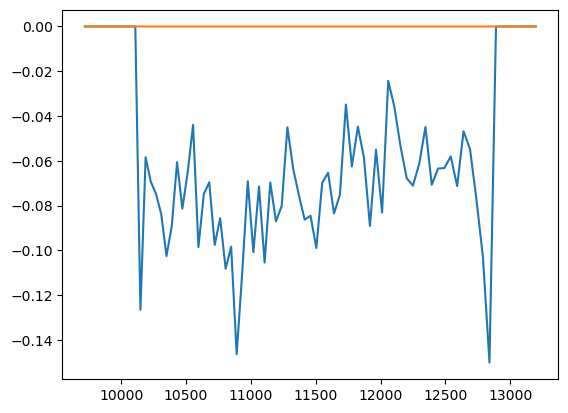

In [18]:
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['flux'])
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['contam'])

In [13]:
import matplotlib.pylab as plt

In [15]:
mb_C.oned_spectrum()

AttributeError: 'function' object has no attribute 'keys'